In [1]:
import numpy as np
import tensorflow as tf
import keras.api as keras
from keras.api.layers import *
import matplotlib.pyplot as plt

2025-03-13 21:41:36.109058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741912896.126443   57138 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741912896.131382   57138 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 21:41:36.148804: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


I0000 00:00:1741912900.192684   57138 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10138 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


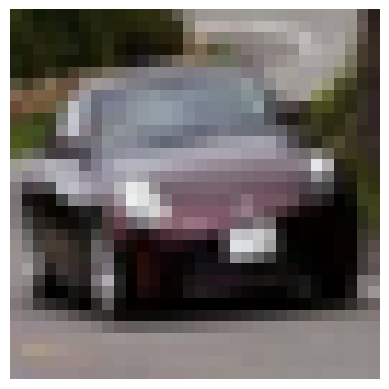

In [2]:
(x_train,y_train),(_,_) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train[:,0] == 1]
x_train = tf.cast(x_train,tf.float32)/255.

n = np.random.randint(0,x_train.shape[0])

data = tf.data.Dataset.from_tensor_slices((x_train)).shuffle(x_train.shape[0]).batch(128,drop_remainder=True)

complete_hist = {
    'loss_dis': [],
    'loss_gen': [],
}

plt.imshow(x_train[n])
plt.axis(False)
plt.show()

In [3]:
def create_discriminator():
    
    input = Input((32,32,3))

    x = Conv2D(64,3,1,'same')(input) # output = (32,32)
    x = LeakyReLU(.2)(x)

    x = Conv2D(128,3,2,'same')(x) # output = (16,16)
    x = LeakyReLU(.2)(x)

    x = Conv2D(128,3,2,'same')(x) # output = (8,8)
    x = LeakyReLU(.2)(x)

    x = Conv2D(256,3,2,'same')(x) # output = (4,4)
    x = LeakyReLU(.2)(x)

    x = Flatten()(x)
    x = Dropout(.4)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)

    return keras.Model(input,x,name='Discriminator')

def create_generator():
    
    input = Input((100,))

    x = Dense(512*4*4)(input)
    x = LeakyReLU(.2)(x)
    x = Reshape((4,4,512))(x)

    x = Conv2DTranspose(128,4,2,'same')(x) # output = (8,8)
    x = LeakyReLU(.2)(x)
    x = Conv2DTranspose(128,4,2,'same')(x) # output = (16,16)
    x = LeakyReLU(.2)(x)
    x = Conv2DTranspose(128,4,2,'same')(x) # output = (32,32)
    x = LeakyReLU(.2)(x)
    x = Conv2D(3,3,1,'same')(x)
    x = Activation('sigmoid')(x)

    return keras.Model(input,x,name='Generator')

gen = create_generator()
dis = create_discriminator()

In [10]:
bce = keras.losses.BinaryCrossentropy()
gen_opt = keras.optimizers.Adam(1e-4,.5)
dis_opt = keras.optimizers.Adam(1e-4,.5)
n = 5
noise_out = tf.random.normal((n**2,100))

In [12]:
@tf.function
def train_step():
    gen_loss,dis_loss = 0.,0.
    gen_loss_iter,dis_loss_iter = 0.,0.
    for batch in data:
        
        noise = tf.random.normal((128,100))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            fake_imgs = gen(noise,training=True)
            true_labels = dis(batch,training=True)
            fake_labels = dis(fake_imgs,training=True)

            gen_loss_iter = bce(tf.ones_like(fake_labels),fake_labels)
            dis_loss_iter = bce(tf.ones_like(true_labels),true_labels) + bce(tf.zeros_like(fake_labels),fake_labels)
        
        gen_gras = gen_tape.gradient(gen_loss_iter,gen.trainable_variables)
        gen_opt.apply_gradients(zip(gen_gras,gen.trainable_variables))

        dis_grads = dis_tape.gradient(dis_loss_iter,dis.trainable_variables)
        dis_opt.apply_gradients(zip(dis_grads,dis.trainable_variables))

        gen_loss += gen_loss_iter
        dis_loss += dis_loss_iter
        gen_loss_iter,dis_loss_iter = 0.,0.

    return gen_loss/tf.cast(len(data),tf.float32),dis_loss/tf.cast(len(data),tf.float32)

In [ ]:
gen = keras.models.load_model()

In [ ]:
EPOCHS = 1400
EPOCH_SAMPLE = 10

loss_dis, loss_gan = 0.,0.
loss_list = np.zeros((EPOCHS,2))
for i in range(EPOCHS):

    # Histórico de Loss
    loss_gen, loss_dis = train_step()
    complete_hist['loss_gen'].append(loss_gen)
    complete_hist['loss_dis'].append(loss_dis)
    
    # Iteração das épocas
    if i % EPOCH_SAMPLE == 0:
        # Print Loss
        print(f'Ep = {i} | Loss_gen = {loss_gen:.4f}; Loss_dis = {loss_dis:.4f}')
        # Salvar uma amostra das imagens
        img_fake = gen(noise_out)
        fig, ax = plt.subplots(n,n,figsize=(10,10))
        ax = ax.ravel()
        for ii in range(n**2):
            ax[ii].imshow(img_fake[ii])
            ax[ii].set_axis_off()
        plt.savefig(f'imgs/fig{i}.png',dpi=800)
        plt.close()

        plt.Figure()
    plt.semilogy(np.array(complete_hist['loss_gen']),label='GEN')
    plt.semilogy(np.array(complete_hist['loss_dis']),label='DIS')
    plt.legend()
    plt.grid(True,'minor')
    plt.savefig('loss.png')
    plt.close()


print('==================== COMPLETE ====================')

# plt.Figure()
# plt.plot(loss_list[:,0],label='Discriminator')
# plt.plot(loss_list[:,1],label='GAN')
# plt.legend()
# plt.show()

Ep = 0 | Loss_gen = 0.7307; Loss_dis = 1.3306
Ep = 10 | Loss_gen = 1.1487; Loss_dis = 1.1091
Ep = 20 | Loss_gen = 0.9685; Loss_dis = 1.2004
Ep = 30 | Loss_gen = 0.9653; Loss_dis = 1.2610
Ep = 40 | Loss_gen = 0.8822; Loss_dis = 1.2595
Ep = 50 | Loss_gen = 0.9180; Loss_dis = 1.1854
Ep = 60 | Loss_gen = 0.9513; Loss_dis = 1.2002
Ep = 70 | Loss_gen = 0.9294; Loss_dis = 1.1497
Ep = 80 | Loss_gen = 0.9638; Loss_dis = 1.1355
Ep = 90 | Loss_gen = 0.9168; Loss_dis = 1.2102
Ep = 100 | Loss_gen = 0.8042; Loss_dis = 1.2122
Ep = 110 | Loss_gen = 0.9340; Loss_dis = 1.2248
Ep = 120 | Loss_gen = 0.8962; Loss_dis = 1.2110
Ep = 130 | Loss_gen = 0.8992; Loss_dis = 1.1832
Ep = 140 | Loss_gen = 0.9139; Loss_dis = 1.2323
Ep = 150 | Loss_gen = 0.8836; Loss_dis = 1.2140
Ep = 160 | Loss_gen = 0.8664; Loss_dis = 1.2111
Ep = 170 | Loss_gen = 0.9293; Loss_dis = 1.1823
Ep = 180 | Loss_gen = 0.8641; Loss_dis = 1.2024
Ep = 190 | Loss_gen = 0.9291; Loss_dis = 1.1751
Ep = 200 | Loss_gen = 0.9544; Loss_dis = 1.1379
Ep 

2025-03-09 16:30:48.518555: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-09 16:30:49.283413: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-09 16:30:49.283481: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-09 16:30:50.372358: W external/local_xla/xla/ts

Média True = 0.3069 
Média False = 0.1678


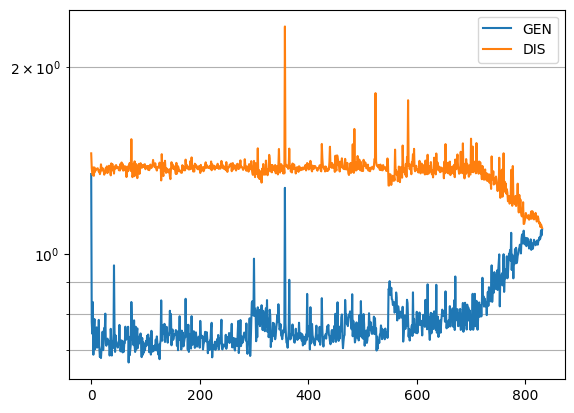

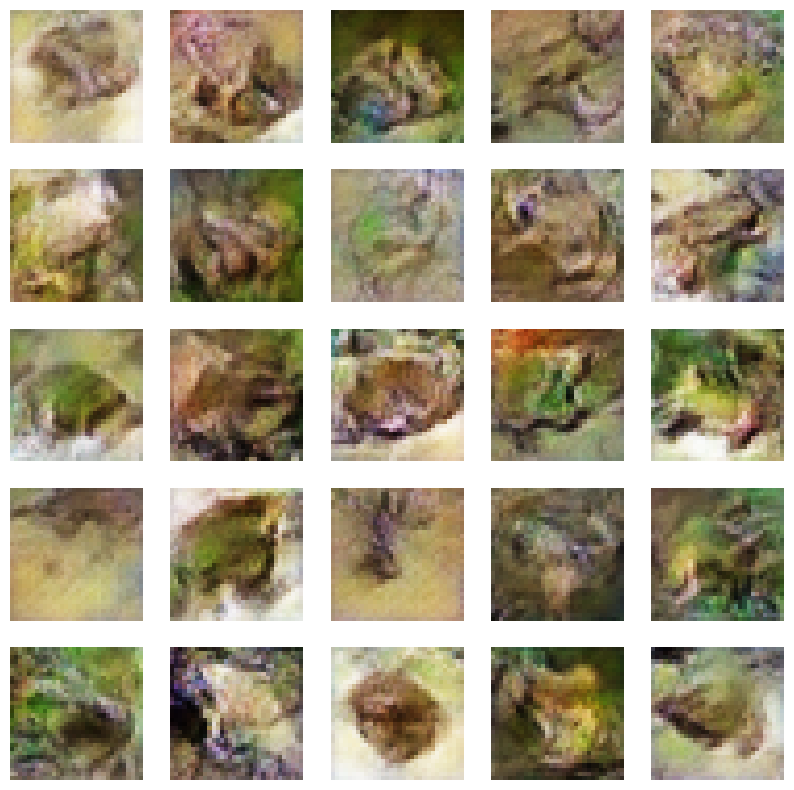

In [27]:
gen.save(f'models/gen_{len(complete_hist['loss_gen'])}_frogs.keras')
dis.save(f'models/dis_{len(complete_hist['loss_gen'])}_frogs.keras')

n = 5

noise_out = tf.random.normal((1000,100))

img_fake = gen(noise_out)
out_true = dis(x_train[0:1000])
out_fake = dis(gen(tf.random.normal((1000,100))))

print(f'Média True = {tf.reduce_mean(out_true):.4f} \nMédia False = {tf.reduce_mean(out_fake):.4f}')

plt.Figure()
plt.semilogy(np.array(complete_hist['loss_gen']),label='GEN')
plt.semilogy(np.array(complete_hist['loss_dis']),label='DIS')
plt.legend()
plt.grid(True,'minor')
plt.show()


fig, ax = plt.subplots(n,n,figsize=(10,10))
ax = ax.ravel()

for i in range(n**2):
    ax[i].imshow(img_fake[i])
    ax[i].set_axis_off()
plt.show()